In [1]:
from hmc_tomography import Distributions
from hmc_tomography import Samplers
from hmc_tomography import Samples
from hmc_tomography import Visualization

# Our trusty imports
import numpy as np
import matplotlib.pyplot as plt

ModuleNotFoundError: No module named 'hmc_tomography'

# 1: Starting simple, sampling the standard normal distribution

First we create an instance of this distribution. This allows us to compute misfits and gradients.

In [2]:
a_simple_distribution = Distributions.StandardNormal1D()

Next, we create a sampler and set the important parameters.

**Try finding these s.t. the acceptance rate is about 0.63!**

In [3]:
# Change things here ----------------------------------------------------------------------------<<<
# Pick a sampler from the submodule, and instantiate it. Try out with RWMH too!
sampler = Samplers.HMC()
# Don't sample too long, don't sample too short
proposals = 1000
# Ideal acceptance rate is 0.63 (HMC) for Gaussians, find a stepsize that does this.
stepsize = 0.5
# ----------------------------------------------------------------------------------------

# Start sampling
sampler.sample(
    "samples_simple_distribution.h5",
    a_simple_distribution,
    proposals=proposals,
    stepsize=stepsize,
    overwrite_existing_file=True,
)

sys:1: Warning: 
Silently overwriting samples file (samples_simple_distribution.h5) if it exists.


**Let's look at the results:**

In [ ]:
with Samples("samples_simple_distribution.h5") as samples:
    print("Samples object content:", samples.numpy)
    print(f"\r\nWith shape: {samples.numpy.shape}")

Good, this thing contains all the samples `[0,:]` and all the misfits `[1,:]`.

**Let's visualize them:**

In [ ]:
with Samples("samples_simple_distribution.h5") as samples:

    # FILL IN HERE ------------------------------------------------------------------------------<<<
    parameter_0 = None  # how can you extract the values from samples?
    misfit = None  # How can you extract the misfits from samples?
    # ---------------------------------------------------------------------

    plt.subplot(2, 1, 1)
    plt.plot(parameter_0, color="k", label="parameter 0")
    plt.xlabel("sample index")
    plt.ylabel("parameter value")
    plt.legend()

    plt.subplot(2, 1, 2)
    plt.semilogy(misfit, "r")
    plt.xlabel("sample index")
    plt.ylabel("misfit")

**A lot of the time, histograms are much easier to read:**

Try changing the bins value to see the effect on the histogram.

In [ ]:
plt.subplot(2, 1, 1)
plt.hist(parameter_0, label="parameter 0", color="k", bins=25, density=True)
plt.xlabel("parameter value")
plt.ylabel("density")
plt.legend()

plt.subplot(2, 1, 2)
plt.hist(misfit, color="r", bins=25)  # Change this guy! bins=5, bins=100! ----------------------<<<
plt.xlabel("misfit")
plt.ylabel("count")

plt.tight_layout()

**Let's compare the sampling result to the exact answer:**

In [ ]:
par_0 = np.linspace(-3, 3, 1000)
misfit_exact = np.exp(-0.5 * (par_0 ** 2)) / (np.pi * 2) ** 0.5
plt.plot(par_0, misfit_exact, label="True probability")
plt.xlabel("parameter value")
plt.hist(
    parameter_0, label="parameter 0 sampling results", color="k", bins=25, density=True
)
plt.xlabel("parameter value")
plt.ylabel("density")
_ = plt.legend()

All this plotting stuff becomes boring quick, so here's an easy function:

In [ ]:
with Samples("samples_simple_distribution.h5") as samples:
    Visualization.marginal(samples, 0)

# 2: Small upgrade, sampling a non-linear distribution

Here we sample a 1-dimensional Laplace distribution, which I have artificially bounded at -0.25:

In [4]:
mean = np.array([[1.5]])
disperion = np.array([[0.75]])
lower_bound = np.array([[-0.25]])

a_more_complicated_distribution = Distributions.Laplace(
    mean, disperion, lower_bounds=lower_bound
)

**Changing the stepsize becomes really boring. Below, you can try enabling _autotuning_. WOW!** 

In [8]:
sampler = Samplers.HMC()

proposals = 25000
stepsize = 0.75e2


sampler.sample(
    "a_more_complicated_distribution.h5",
    a_more_complicated_distribution,
    proposals=proposals,
    stepsize=stepsize,
    autotuning=True,  # Try enabling this. ----------------------------------------------------------<<<
    overwrite_existing_file=True,
    learning_rate=0.51,  # Only change this if you're bored.
)

sys:1: Warning: 
Silently overwriting samples file (a_more_complicated_distribution.h5) if it exists.


Inspecting the stepsizes is always a good idea to see if we will need any burn-in:

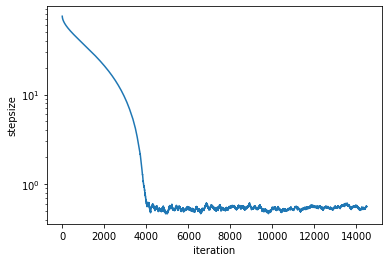

In [9]:
sampler.plot_stepsizes()

Let's check our marginal now. 

**If you think the marginal is incorrent, try visualizing it while accounting for burn in. 🔥🔥** E.g. try discarding the first 1000 samples by setting burn in equal to that number.

In [ ]:
with Samples(
    "a_more_complicated_distribution.h5", burn_in=0  # Check this line for burn-in ------------------<<<
) as samples:
    Visualization.marginal(samples, 0, bins=50)

    plt.plot(samples.misfits, "r")
    plt.xlabel("sample index")
    plt.ylabel("misfit")

# 3: The ultimate test for a statistician, BAYES RULE

What if we **combine** two distributions? Should one be able to hav esuch power?

In [ ]:
posterior = Distributions.BayesRule(
    [a_simple_distribution, a_more_complicated_distribution]
)

Work pretty flawlessly:

In [ ]:
proposals = 50000

sampler.sample(
    "posterior_samples.h5",
    posterior,
    proposals=proposals,
    autotuning=True,  # Cheating, but hey
    overwrite_existing_file=True,
)

Again, assess burn-in to be safe:

In [ ]:
sampler.plot_stepsizes()

In [ ]:
with Samples(
    "posterior_samples.h5",
    burn_in=0,  # Change that number in here to something reasonable
) as samples:
    Visualization.marginal(samples, 0, bins=50)

# 4: Your _own_ inverse problem

In [ ]:
import jax  # This package is too cool.

Making your own class in this package is really easy! There is only one thing missing here still, **the forward model calculation. Write this guy yourself.**

In [ ]:
class EarthquakeLocation1D(Distributions._AbstractDistribution):
    "1D earthquake location for 2 events with unknown velocity."

    dimensions = 3

    def __init__(self, observation_1, observation_2, uncertainty):

        # Storing the observed data
        self.observation_1 = observation_1
        self.observation_2 = observation_2
        self.uncertainty = uncertainty

        # The "I didnt't like calculus" approach, choice #1 in Silicon Valley
        self.gradient = jax.jit(jax.grad(self.misfit))

    def misfit(self, model_vector):
        """The misfit function. Typically contains a forward model and a measure that
        compares synthetics with observations, such as the L2 misfit."""

        # Deconstruct the vector
        medium_velocity = model_vector[0, 0]
        distance_event_1 = model_vector[1, 0]
        distance_event_2 = model_vector[2, 0]

        predicted_arrival_time_event_1 = None  # You can do this, come on!
        predicted_arrival_time_event_2 = None  # ------------------------------------------------------<<<

        data_residual_1 = self.observation_1 - predicted_arrival_time_event_1
        data_residual_2 = self.observation_2 - predicted_arrival_time_event_2

        l2_misfit = (
            0.5 * (data_residual_1 ** 2 + data_residual_2 ** 2) / (uncertainty ** 2)
        )

        return l2_misfit

    def gradient(model_vector):
        "I didn't do a PhD to derive analytical gradients."
        pass

Now let's 'create' some true data! 

In [ ]:
# True parameters to find in the inversion:
# medium_velocity = 2.75 km/s
# distance_event_1 = 55.825 km
# distance_event_2 = 10.175 km

# Observed arrival times (uncertainty = 1.0 sec)
arrival_time_1 = 20.3  #        = 55.825/2.75
arrival_time_2 = 3.7  #         = 10.175/2.75
uncertainty = 1.0

# And wrapping everything up in a likelihood function.
eq_likelihood = EarthquakeLocation1D(arrival_time_1, arrival_time_2, uncertainty)

Now we make our starting model be **something really really bad**, just to prove how good my code is (spoiler, it isn't that great).

In [ ]:
m_starting = np.array([[4.0], [10.0], [10.0]])

# Initial misfit and gradient, just to check all the bits and pieces are moving.
m = eq_likelihood.misfit(m_starting)
g = eq_likelihood.gradient(m_starting)

print(m)
print(g)

A finite difference test to make sure our fancy 3rd party software _JAX_ does what it should do.

In [ ]:
def first_finite_differences(f, x):
    eps = 1e-10
    g = np.empty_like(x)
    for i, ix in enumerate(x):
        x_acc = x.copy()
        x_acc[i] += eps
        g[i] = (f(x_acc) - f(x)) / eps
    return g


first_finite_differences(eq_likelihood.misfit, m_starting)

That's pretty cool!

Now, on to sampling:

In [ ]:
sampler = Samplers.RWMH()

sampler.sample(
    "samples_eq.h5",
    eq_likelihood,
    stepsize=1e-1,
    proposals=100000,
    online_thinning=10,
    initial_model=m_starting,
)

In [ ]:
with Samples("samples_eq.h5", burn_in=0) as samples:
    Visualization.marginal_grid(samples, [0, 1, 2], bins=50)

That's a pretty bad result, maybe we should constrain ourselves a bit more.

In [ ]:
# Create a vector for conveniece
ones = np.ones((1, 1))

# Prior normal distribution on velocity
prior_velocity = Distributions.Normal(ones * 2.65, ones * (0.1 ** 2))

# Extremely wide uniform on distance
prior_distance_1 = Distributions.Uniform(lower_bounds=ones * 0, upper_bounds=ones * 100)
prior_distance_2 = prior_distance_1

prior = Distributions.CompositeDistribution(
    [prior_velocity, prior_distance_1, prior_distance_2]
)

print(prior.dimensions)

Combining our data and prior to make a posterior:

In [ ]:
eq_posterior = Distributions.BayesRule([prior, eq_likelihood])

In [ ]:
sampler = Samplers.HMC()

sampler.sample(
    "samples_eq_posterior.h5",
    eq_posterior,
    stepsize=1e-1,
    proposals=1000,
    online_thinning=1,
    initial_model=m_starting,
)

In [ ]:
with Samples("samples_eq_posterior.h5", burn_in=0) as samples:
    Visualization.marginal_grid(samples, [0, 1, 2], bins=50)

Using an estimate of the posterior covariance, we can dramaticallyt speed up sampling:

In [ ]:
sampler = Samplers.RWMH()

stepsize = np.array([[0.1], [3.0], [2.5]])

sampler.sample(
    "samples_eq_posterior_rwmh.h5",
    eq_posterior,
    stepsize=stepsize,
    proposals=100000,
    online_thinning=10,
    initial_model=m_starting,
)

In [ ]:
with Samples("samples_eq_posterior_rwmh.h5", burn_in=0) as samples:
    Visualization.marginal_grid(samples, [0, 1, 2], bins=25)

**Great success!**